# Entrance Pupil Masks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import time
% matplotlib inline

C:\Python34\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


## Utility functions

In [2]:
def cart2pol(x,y):
    """
    Takes cartesian (2D) coordinates and transforms them into polar.
    """
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    """
    Takes polar coordinates and transforms them into cartesian.
    """
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

## Elliptical Pupil

In [32]:
def make_elliptical_pupil(N, aspect_ratio, a, write=False, plot=False):
    """
    Make an elliptical pupil on a NxN grid with semi-major axis a and semi-minor axis b=aspect_ratio*a
    Set :param write: to True in order to save the pupil in a fits file.
    """
    b = a*aspect_ratio
    x = np.arange(-N/2, N/2)
    y = np.arange(-N/2, N/2)
    X, Y = np.meshgrid(x,y)
    pupil = np.exp(-np.sqrt((X/a)**2 + (Y/b)**2)**1000)
    if write:
        if a != b:
            hdu = fits.PrimaryHDU(data=pupil)
            hdu.header['TYPE']= 'pupil'
            hdu.header['SHAPE']= 'ellipse'
            hdu.header['MAJ_AX'] = str(a)
            hdu.header['MIN_AX'] = str(b)
            hdu.header['DATE'] = time.strftime("%d/%m/%Y")
            hdu.writeto("Ellipse_pupil_N=%i_a=%.1f_b=%.1f.fits" % (N, a, b))
        elif a == b:
            hdu = fits.PrimaryHDU(data=pupil)
            hdu.header['TYPE']= 'pupil'
            hdu.header['SHAPE']= 'circle'
            hdu.header['RADIUS'] = str(a)
            hdu.header['DATE'] = time.strftime("%d/%m/%Y")
            hdu.writeto("Circular_pupil_N=%i_R=%.1f.fits" % (N, a))
    if plot:
        plt.imshow(pupil, interpolation='nearest', cmap='gray')
        plt.colorbar()
    return

## Pupil with central obscuration

In [3]:
def make_annular_pupil(N, apRad, inRad_fact, write=False, plot=False):
    """
    Make a pupil simulating that from the VLT telescope on a NxN grid.
    """
    Rin = apRad*inRad_fact # inner radius 
    x = np.arange(-N/2, N/2)
    y = np.arange(-N/2, N/2)
    X, Y = np.meshgrid(x,y)
    Rho, Theta = cart2pol(X,Y)
    
    
    ANpupil = (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**200))
    
    if write:
        hdu = fits.PrimaryHDU(data=ANpupil)
        hdu.header['TYPE']= 'pupil'
        hdu.header['SHAPE']= 'ANNULAR'
        hdu.header['AP_RAD'] = str(apRad)
        hdu.header['R_IN'] = str(Rin)
        hdu.header['SPID'] = 'NO'
        hdu.header['SP_WID'] = '-'
        hdu.header['DATE'] = time.strftime("%d/%m/%Y")
        hdu.writeto("VLT_pupil_N=%i_apRad_%.1f_inRadFact_%.2f.fits" % (N, apRad, inRad_fact))
    if plot:
        plt.imshow(ANpupil, interpolation='nearest', cmap='gray')
        plt.colorbar()
    return ANpupil

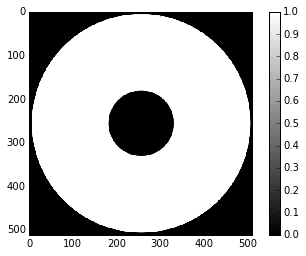

In [4]:
a = make_annular_pupil(512, 250, 0.3, plot=True)

## VLT Pupil
Pupil mask of the VLT telescope

In [3]:
def make_VLT_pupil(N, apRad, write=False, plot=False):
    """
    Make a pupil simulating that from the VLT telescope on a NxN grid.
    """
    Rin = apRad*0.15 # inner radius 
    sp_width = apRad*0.01 # spider width
    x = np.arange(-N/2, N/2)
    y = np.arange(-N/2, N/2)
    X, Y = np.meshgrid(x,y)
    Rho, Theta = cart2pol(X,Y)
    spider1 = 1 - np.exp(-((1/(1-np.sqrt(2)*Rin/apRad)*(X-Rin)+Y)/sp_width)**6)
    spider2 = 1 - np.exp(-((-1/(1-np.sqrt(2)*Rin/apRad)*(X-Rin)+Y)/sp_width)**6)
    spider3 = 1 - np.exp(-((1/(1-np.sqrt(2)*Rin/apRad)*(-X-Rin)+Y)/sp_width)**6)
    spider4 = 1 - np.exp(-((-1/(1-np.sqrt(2)*Rin/apRad)*(-X-Rin)+Y)/sp_width)**6)
    
    spider1[X<Rin] = 1 
    spider2[X<Rin] = 1
    spider3[X>-Rin] = 1 
    spider4[X>-Rin] = 1
    
    VLTpupil = (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**200))*spider1*spider2*spider3*spider4
    
    if write:
        hdu = fits.PrimaryHDU(data=VLTpupil)
        hdu.header['TYPE']= 'pupil'
        hdu.header['SHAPE']= 'VLT'
        hdu.header['AP_RAD'] = str(apRad)
        hdu.header['R_IN'] = str(Rin)
        hdu.header['SP_WID'] = str(sp_width)
        hdu.header['DATE'] = time.strftime("%d/%m/%Y")
        hdu.writeto("VLT_pupil_N=%i_apRad_%.1f.fits" % (N, apRad))
    if plot:
        plt.imshow(VLTpupil, interpolation='nearest', cmap='gray')
        plt.colorbar()
    return VLTpupil

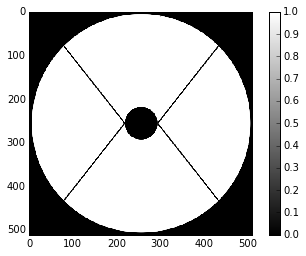

In [4]:
v = make_VLT_pupil(512, 250, write=True, plot=True)

## Segmented Pupil

In [ ]:
class HexagonalPupil:
    def __init__(self, N):
        self.xx,self.yy = np.meshgrid(np.arange(-N/2, N/2), np.arange(-N/2, N/2))
        self.transmission = np.zeros((self.N, self.N))
        
    def one_Hex(self):
        X = self.xx
        Y = self.yy
        w_rect = np.where((np.abs(X)<=0.5*20) & (np.abs(Y)<= np.sqrt(3)*0.5*20))
        w_left_tri = np.where( (X <= -0.5*20) & (x >= -1*20) & (np.abs(Y)<=(X+1*20)*np.sqrt(3)))
        w_right_tri = np.where( (X >= 0.5*20) & (x <= 1*20) & (np.abs(Y)<=(-X+1*20)*np.sqrt(3)))
        self.transmission[w_rect]=1
        self.transmission[w_right_tri]=1
        self.transmission[w_left_tri]=1
        

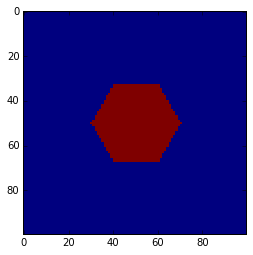

In [2]:
transmission = np.zeros((100, 100))
x = np.arange(-50,50)
y = np.arange(-50, 50)
X,Y = np.meshgrid(x,y)
w_rect = np.where((np.abs(X)<=0.5*20) & (np.abs(Y)<= np.sqrt(3)*0.5*20))
w_left_tri = np.where( (X <= -0.5*20) & (x >= -1*20) & (np.abs(Y)<=(X+1*20)*np.sqrt(3)))
w_right_tri = np.where( (X >= 0.5*20) & (x <= 1*20) & (np.abs(Y)<=(-X+1*20)*np.sqrt(3)))
transmission[w_rect]=1
transmission[w_right_tri]=1
transmission[w_left_tri]=1
plt.imshow(transmission, interpolation='nearest')

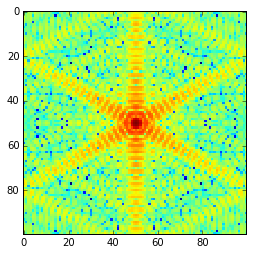

In [6]:
fp = np.fft.fftshift(np.fft.fft2(transmission))
plt.imshow(np.log(abs((fp))), interpolation='nearest')